In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Feb  6 21:57:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.35       Driver Version: 471.35       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    24W /  N/A |   1729MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Pre-processing

### Reading the data converting into TimeSeries format

In [ ]:
COLUMN_LIST_GIVEN = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Temperature', 'Cloud Type', 'Dew Point', 'Fill Flag', 
           'Relative Humidity', 'Solar Zenith Angle', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed']

In [ ]:
def convert_ts_csv_to_df(csvfile):
    '''Take the CSV file along with the path and return dataframe'''
    df = pd.read_csv(csvfile)
    df.insert(loc=0, column='Date', 
                value=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
    df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    df.set_index(keys='Date', inplace=True)
    df['Clearsky DHI'] = df['Clearsky DHI'].replace(to_replace=0, value=1)
    df['Clearsky DNI'] = df['Clearsky DNI'].replace(to_replace=0, value=1)
    df['Clearsky GHI'] = df['Clearsky GHI'].replace(to_replace=0, value=1)
    df=df[COLUMN_LIST_GIVEN]
    return df

In [ ]:
training_csv = 'data/train.csv'
testing_csv = 'data/test.csv'

In [ ]:
df_solar = convert_ts_csv_to_df(training_csv)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Solar Zenith Angle,Pressure,Precipitable Water,Wind Direction,Wind Speed
Date,,,,,,,,,,,,,
2017-01-21 21:00:00,106,545,299,20.0,6,20.0,4,100.00,69.25,990,3.602,198.4,4.2
2016-12-17 20:30:00,70,701,313,21.0,0,18.0,1,84.65,69.72,1000,2.751,194.6,3.6


In [ ]:
# Reading the test dataset as Val
# Train dataset shall be split into Train and Test
# Val is read to understand the data and null values
df_solar_test = convert_ts_csv_to_df(testing_csv)
df_solar_test.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Solar Zenith Angle,Pressure,Precipitable Water,Wind Direction,Wind Speed
Date,,,,,,,,,,,,,
2019-07-11 13:00:00,NaN,NaN,NaN,27.9,0,24.8,0,83.24,62.28,1005,5.1,189,2.5
2019-05-03 20:00:00,NaN,NaN,NaN,27.9,0,20.4,0,63.82,37.16,1003,3.9,329,0.8


In [ ]:
df_solar.shape, df_solar_test.shape

((175296, 13), (17520, 13))

### Data Check

##### Null Check

In [ ]:
df_solar.isnull().sum()

Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Temperature           0
Cloud Type            0
Dew Point             0
Fill Flag             0
Relative Humidity     0
Solar Zenith Angle    0
Pressure              0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
dtype: int64

In [ ]:
df_solar_test.isnull().sum()

Clearsky DHI          17520
Clearsky DNI          17520
Clearsky GHI          17520
Temperature               0
Cloud Type                0
Dew Point                 0
Fill Flag                 0
Relative Humidity         0
Solar Zenith Angle        0
Pressure                  0
Precipitable Water        0
Wind Direction            0
Wind Speed                0
dtype: int64

# Feature Selection

##### Datatype Check and convert to floats for Scaling data

In [ ]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Clearsky DHI        175296 non-null  int64  
 1   Clearsky DNI        175296 non-null  int64  
 2   Clearsky GHI        175296 non-null  int64  
 3   Temperature         175296 non-null  float64
 4   Cloud Type          175296 non-null  int64  
 5   Dew Point           175296 non-null  float64
 6   Fill Flag           175296 non-null  int64  
 7   Relative Humidity   175296 non-null  float64
 8   Solar Zenith Angle  175296 non-null  float64
 9   Pressure            175296 non-null  int64  
 10  Precipitable Water  175296 non-null  float64
 11  Wind Direction      175296 non-null  float64
 12  Wind Speed          175296 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 18.7 MB


In [ ]:
df_solar = df_solar.astype(np.float64)

In [ ]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Clearsky DHI        175296 non-null  float64
 1   Clearsky DNI        175296 non-null  float64
 2   Clearsky GHI        175296 non-null  float64
 3   Temperature         175296 non-null  float64
 4   Cloud Type          175296 non-null  float64
 5   Dew Point           175296 non-null  float64
 6   Fill Flag           175296 non-null  float64
 7   Relative Humidity   175296 non-null  float64
 8   Solar Zenith Angle  175296 non-null  float64
 9   Pressure            175296 non-null  float64
 10  Precipitable Water  175296 non-null  float64
 11  Wind Direction      175296 non-null  float64
 12  Wind Speed          175296 non-null  float64
dtypes: float64(13)
memory usage: 18.7 MB


##### Feature update based on domain

In [ ]:
print('''
Source: https://www.yellowhaze.in/solar-irradiance/
Global Horizontal Irradiance (GHI) = Direct Normal Irradiance (DNI)* cos(solar zenith angle)  +  Diffused Horizontal Irradiance (DHI)''')


Source: https://www.yellowhaze.in/solar-irradiance/
Global Horizontal Irradiance (GHI) = Direct Normal Irradiance (DNI)* cos(solar zenith angle)  +  Diffused Horizontal Irradiance (DHI)


In [ ]:
df_solar['Solar Zenith Angle'].describe()

count    175296.000000
mean         89.729463
std          40.085451
min           8.550000
25%          56.450000
50%          89.860000
75%         123.060000
max         171.550000
Name: Solar Zenith Angle, dtype: float64

In [ ]:
print('''This shows the Zenith Angle is given in degrees with a min or 35 and max of 171 approximately''')

This shows the Zenith Angle is given in degrees with a min or 35 and max of 171 approximately


In [ ]:
from math import cos, radians

In [ ]:
df_solar['Cos Zenith'] = df_solar['Solar Zenith Angle'].apply(lambda x: cos(radians(x)))

In [ ]:
df_solar['Cos Zenith'].describe()

count    175296.000000
mean          0.003547
std           0.595196
min          -0.989144
25%          -0.545517
50%           0.002443
75%           0.552664
max           0.988886
Name: Cos Zenith, dtype: float64

In [ ]:
df_solar.drop(columns='Solar Zenith Angle', inplace=True)

In [ ]:
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith
Date,,,,,,,,,,,,,
2010-02-25 16:30:00,96.0,990.0,798.0,4.0,0.0,-4.0,0.0,53.48,1000.0,0.351,309.7,5.1,0.708340
2010-10-19 11:30:00,1.0,1.0,1.0,13.0,1.0,11.0,0.0,100.00,1000.0,1.752,252.2,1.7,-0.057041


In [ ]:
df_solar.shape

(175296, 13)

### Adding the Significance of Seasonality into TS
Since we using Deep Learning, the significance of Timestamp is lost and the sinificance behaviour of data with respect to Seasonality. In order to avoid it, these parameters are added
Ref: https://www.avanwyk.com/encoding-cyclical-features-for-deep-learning/#:~:text=Many%20features%20commonly%20found%20in,seasonal%2C%20tidal%20or%20astrological%20data.

https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [ ]:
# Getting the time in seconds
df_solar['ts'] = df_solar.index.map(pd.Timestamp.timestamp)
# Adding columns based on Timestamp to understand Daily and Yearly seasonality
day = 60*60*24
year = 365.2425*day

df_solar['ts_Day_sin'] = np.sin(df_solar['ts'] * (2* np.pi / day))
df_solar['ts_Day_cos'] = np.cos(df_solar['ts'] * (2 * np.pi / day))
df_solar['ts_Year_sin'] = np.sin(df_solar['ts'] * (2 * np.pi / year))
df_solar['ts_Year_cos'] = np.cos(df_solar['ts'] * (2 * np.pi / year))
df_solar.drop(columns='ts', inplace=True)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith,ts_Day_sin,ts_Day_cos,ts_Year_sin,ts_Year_cos
Date,,,,,,,,,,,,,,,,,
2015-09-19 18:30:00,96.0,921.0,863.0,32.0,0.0,17.0,0.0,41.29,1000.0,2.517,17.5,2.8,0.832341,-0.991445,0.130526,-0.978508,-0.206208
2017-03-17 01:00:00,1.0,1.0,1.0,5.0,0.0,1.0,0.0,76.22,1010.0,1.220,289.7,1.2,-0.289366,0.258819,0.965926,0.963902,0.266256


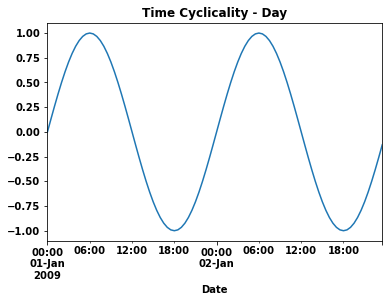

In [ ]:
df_solar['ts_Day_sin'][:48*2].plot()
plt.title("Time Cyclicality - Day")
plt.show()

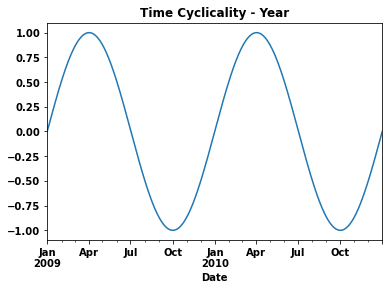

In [ ]:
df_solar['ts_Year_sin'][:48*365*2].plot()
plt.title("Time Cyclicality - Year")
plt.show()

### Scaling of Data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scalar_std_fs = StandardScaler()

##### Small trick to ensure we can perform inverse transform

In [ ]:
scalar_std_fs = scalar_std_fs.fit(df_solar)

In [ ]:
df_solar.shape

(175296, 17)

In [ ]:
df_solar_sc = pd.DataFrame(data=scalar_std_fs.transform(df_solar), index=df_solar.index,  columns=df_solar.columns)
df_solar_sc.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith,ts_Day_sin,ts_Day_cos,ts_Year_sin,ts_Year_cos
Date,,,,,,,,,,,,,,,,,
2017-07-24 00:30:00,-0.824148,-0.891737,-0.775614,0.864718,1.806671,1.151133,-0.112603,0.215652,-0.536619,1.367357,0.363808,-0.439092,0.016033,0.184592,1.402115,-0.522555,-1.314029
2014-03-10 14:30:00,1.010119,1.088886,0.748918,-0.141648,-0.840696,-0.312859,-0.112603,-0.448536,-0.536619,-0.630089,1.228328,-0.127055,0.868150,-0.860919,-1.121971,1.310649,0.531234


### Feature Selection

Text(0.5, 1.0, 'Correlation Matrix')

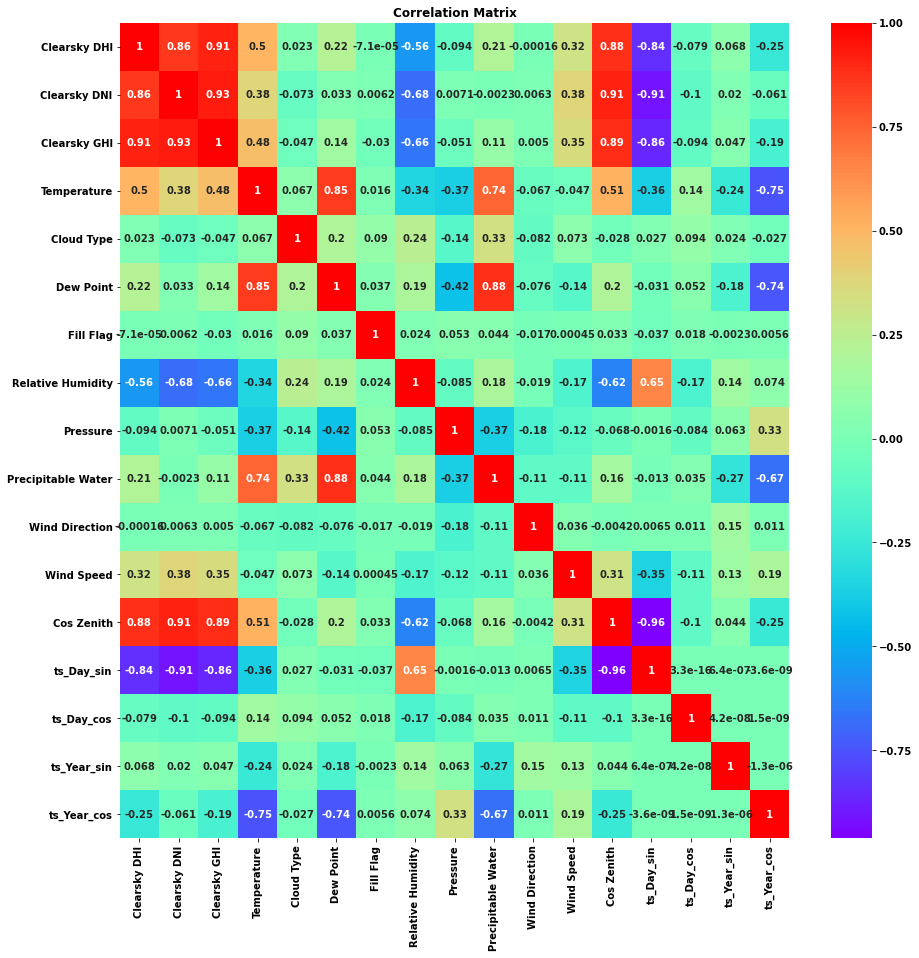

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_solar_sc.corr(), annot=True, cmap='rainbow')
plt.title('Correlation Matrix')

In [ ]:
print('''
Observation: 'Cloud Type', 'Pressure', 'Fill Flag', 'Pressure', 'Wind Direction', 'Wind Speed' have very low correlation with other features.
Solar Zenith Angle, Relative Humidity, Temperature, TS Day have correlation with Clearsky DHI, Clearsky DNI, Clearsky GHI and TS Year have correlation with Temperature Precipitable Water''')


Observation: 'Cloud Type', 'Pressure', 'Fill Flag', 'Pressure', 'Wind Direction', 'Wind Speed' have very low correlation with other features.
Solar Zenith Angle, Relative Humidity, Temperature, TS Day have correlation with Clearsky DHI, Clearsky DNI, Clearsky GHI and TS Year have correlation with Temperature Precipitable Water


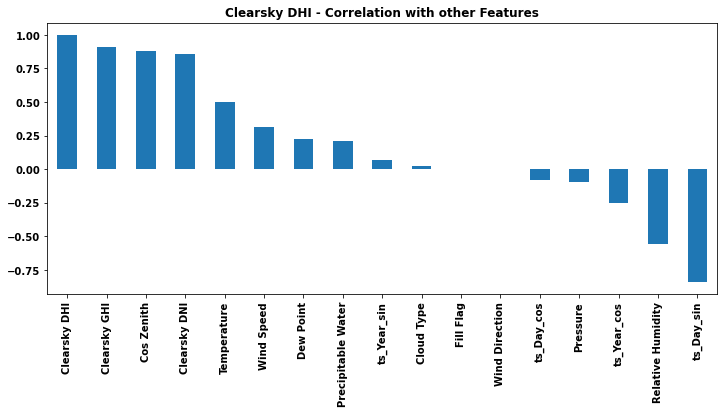

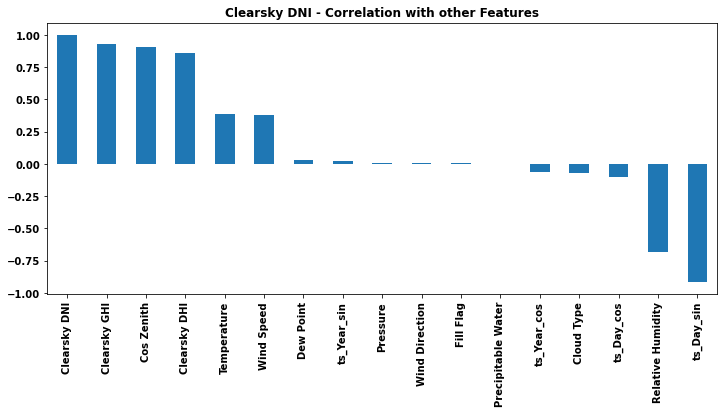

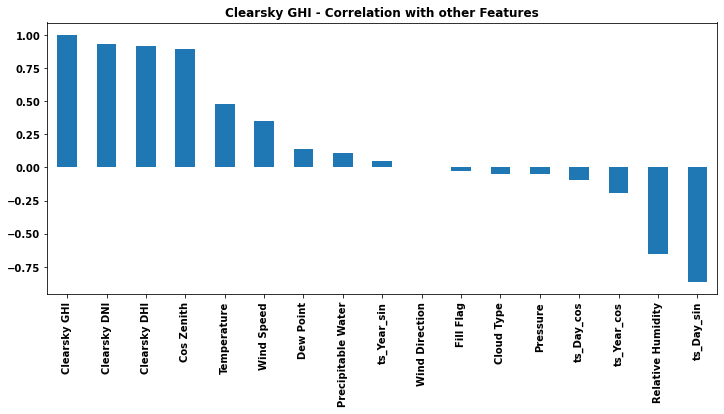

In [ ]:
df_solar_sc.corr()['Clearsky DHI'].sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.title('Clearsky DHI - Correlation with other Features')
plt.show()
df_solar_sc.corr()['Clearsky DNI'].sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title('Clearsky DNI - Correlation with other Features')
plt.show()
df_solar_sc.corr()['Clearsky GHI'].sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title('Clearsky GHI - Correlation with other Features')
plt.show()

##### Any Non-linear regression model can be selected, Choose XGBoost

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

##### Feature Selection for Clearsky GHI since GHI constitues both DHI, DHI and Zenith Angle

In [ ]:
y = df_solar_sc['Clearsky GHI']
X = df_solar_sc.drop(columns='Clearsky GHI', axis=1)

In [ ]:
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
model_xgb.feature_importances_

array([4.3055901e-04, 4.9750917e-03, 2.2409757e-04, 5.1668508e-06,
       5.1780359e-04, 9.5268970e-06, 8.3941568e-06, 4.2294396e-06,
       2.3650103e-03, 4.9040673e-06, 4.5308711e-06, 9.8812002e-01,
       1.4685062e-03, 1.6244006e-04, 2.7724422e-04, 1.4225190e-03],
      dtype=float32)

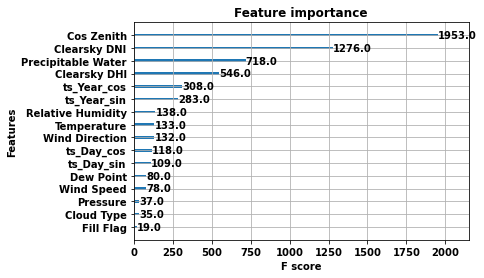

In [ ]:
plot_importance(model_xgb)
plt.show()

### Droping not so significant columns

In [ ]:
# Using smaller dimensions
COLUMNS_DROPPED = ['Cloud Type', 'Pressure', 'Fill Flag', 'Wind Speed', 'Dew Point', 'Wind Direction']

# Dropping less dimensions - to add more features to the data
# COLUMNS_DROPPED = ['Cloud Type', 'Pressure', 'Fill Flag']


In [ ]:
df_solar.drop(columns=COLUMNS_DROPPED, inplace=True)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Relative Humidity,Precipitable Water,Cos Zenith,ts_Day_sin,ts_Day_cos,ts_Year_sin,ts_Year_cos
Date,,,,,,,,,,,
2018-01-18 02:00:00,1.0,1.0,1.0,-5.5,60.64,0.200,-0.625379,0.500000,0.866025,0.295591,0.955315
2017-12-09 17:00:00,97.0,905.0,614.0,6.0,76.48,0.691,0.571716,-0.965926,-0.258819,-0.368398,0.929668


In [ ]:
df_solar.shape

(175296, 11)

In [ ]:
print('''
Precipitable Water, Cos of Zenith Angle along with time of year components are considered for further analysis
To also reduce the curse of dimensionality'''
)


Precipitable Water, Cos of Zenith Angle along with time of year components are considered for further analysis
To also reduce the curse of dimensionality


# Model Building Start

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, RepeatVector, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TimeDistributed

### Consider only last 3 years data

### Data Generation for Time Series

In [ ]:
def preprocess_cvs_into_ts(csvfile):
    '''Take the CSV file along with the path and return dataframe'''
    df = pd.read_csv(csvfile)
    df.insert(loc=0, column='Date', 
                value=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
    df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    df.set_index(keys='Date', inplace=True)
    
    # Updating 0 to 1 to avoid exploding gradiant problem
    # df['Clearsky DHI'] = df['Clearsky DHI'].replace(to_replace=0, value=1)
    # df['Clearsky DNI'] = df['Clearsky DNI'].replace(to_replace=0, value=1)
    # df['Clearsky GHI'] = df['Clearsky GHI'].replace(to_replace=0, value=1)
    #df=df[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Temperature', 'Cloud Type', 'Dew Point', 'Fill Flag', 'Relative Humidity', 'Solar Zenith Angle', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed']]
    df = df[COLUMN_LIST_GIVEN]
    return df



In [ ]:
# This is used to try TimeDistributed
# COLUMNS_SELECTED = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

# Only few major features to reduce dimensions
# COLUMNS_SELECTED = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cos Zenith', 
#                     'Precipitable Water', 'ts_Year_sin', 'ts_Year_cos']

# Adding more features
COLUMNS_SELECTED = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cos Zenith', 'Precipitable Water', 
                    'ts_Year_sin', 'ts_Year_cos',  'ts_Day_sin', 'ts_Day_cos', 'Temperature', 'Relative Humidity']

In [ ]:
def preprocess_ts_features(df):
    '''This shall ensure the time series features are added and 
    non-significant features are removed'''
    
    # Cos of Zenith angle contributes GHI
    df['Cos Zenith'] = np.cos(np.deg2rad(df['Solar Zenith Angle']))
    
    # Adding the time series features into the dataset for Seasonality
    sec_in_day = 60*60*24
    sec_in_year = 365.2425*sec_in_day
    df['ts'] = df.index.map(pd.Timestamp.timestamp)
    df['ts_Day_sin'] = np.sin(df['ts'] * (2* np.pi / sec_in_day))
    df['ts_Day_cos'] = np.cos(df['ts'] * (2 * np.pi / sec_in_day))
    df['ts_Year_sin'] = np.sin(df['ts'] * (2 * np.pi / sec_in_year))
    df['ts_Year_cos'] = np.cos(df['ts'] * (2 * np.pi / sec_in_year))
    
    # Ordering only the selected Columns in a proper order for further processing
    df = df[COLUMNS_SELECTED]
    return df

In [ ]:
df_solar = preprocess_cvs_into_ts(training_csv)
df_solar = preprocess_ts_features(df_solar)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cos Zenith,Precipitable Water,ts_Year_sin,ts_Year_cos,ts_Day_sin,ts_Day_cos,Temperature,Relative Humidity
Date,,,,,,,,,,,
2014-10-01 18:30:00,143,819,785,0.783151,3.027,-0.999996,0.002907,-0.991445,0.130526,29.0,52.08
2015-08-13 17:30:00,147,852,961,0.954240,3.383,-0.663793,-0.747917,-0.991445,-0.130526,34.0,45.25


In [ ]:
df_solar.shape

(175296, 11)

##### Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar_std_ts = StandardScaler()

In [ ]:
scalar_std_ts = scalar_std_ts.fit(df_solar)
solar_data_sc = scalar_std_ts.transform(df_solar)
df_solar_data = pd.DataFrame(data=solar_data_sc, index=df_solar.index, columns=df_solar.columns)
solar_data_sc.shape

(175296, 11)

##### Data Generation
1. Take the values of Dataframe for a given batch length and Predict the values of 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI' for the next row.
2. Move the series by 1 row, repeat step 1

In [ ]:
# Daily there around 48 observations
# Weekly there are around 48*7 = 336 observations
# Monthly there are around 48*30 = 1440 observations
# Yearly there are around 48*365 = 17520 observations

# Ensuring the that total length is not more than 3 years since the model training is taking lot of time
# Also to handle out of memory issues
total_data_len = solar_data_sc.shape[0]
if solar_data_sc.shape[0] > 17520*3:
    total_data_len = 17520*3
else:
    total_data_len = solar_data_sc.shape[0]

batch_input_len = 48
batch_output_len = 1
features_len = 11
# train_data_start = total_data_len - batch_input_len*4
train_data_start = total_data_len
print(f'''
The total length of input {total_data_len} and the batch length is {batch_input_len} with features {features_len}
The training start {train_data_start}''')


The total length of input 52560 and the batch length is 48 with features 11
The training start 52560


In [ ]:
def ts_data_generator(data_arr, batch_len):
    X = []
    y = []
    for i in range(len(data_arr)-batch_len):
        X_rows = [row for row in data_arr[i:i+batch_len]]
        X.append(X_rows)
        y_row = [data_arr[i+batch_len][0],data_arr[i+batch_len][1], data_arr[i+batch_len][2]]
        y.append(y_row)
    return np.array(X), np.array(y)

In [ ]:
X, y = ts_data_generator(solar_data_sc[-train_data_start:], batch_input_len)

##### Split the train csv data into train and val

In [ ]:
train_split = np.int(X.shape[0]*0.7)

X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:], y[train_split:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((36758, 48, 11), (36758, 3), (15754, 48, 11), (15754, 3))

### Build the Model

In [ ]:
input_shape = (batch_input_len, features_len)
learning_rate = 0.0001

In [ ]:
def build_GRU_trans1(input_shape, lr):
    l0 = Input(shape=input_shape)

    l1 = GRU(units=64, activation='relu', recurrent_dropout=.3, return_sequences=True, kernel_initializer='he_normal')(l0)
    l1 = BatchNormalization()(l1)
    l1 = Dropout(rate=.3)(l1)
    l1 = GRU(units=64, activation='relu', recurrent_dropout=.3, kernel_initializer='he_normal')(l1)
    
    
    l2 = RepeatVector(input_shape[1])(l1)
    
    l3 = GRU(units=64, activation='relu', recurrent_dropout=.3, return_sequences=True, kernel_initializer='he_normal')(l2)
    l3 = BatchNormalization()(l3)
    l3 = Dropout(rate=.3)(l3)
    l3 = GRU(units=64, activation='relu', recurrent_dropout=.3, kernel_initializer='he_normal')(l3)
    
    y = Flatten()(l3)
    y = Dense(units=10, activation='relu')(y)
    y = Dense(units=3, activation='linear')(y)

    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [ ]:
def build_LSTM_trans1(input_shape, lr):
    l0 = Input(shape=input_shape)

    l1 = LSTM(units=48, activation='relu', recurrent_dropout=.2, return_sequences=True, kernel_initializer='he_normal')(l0)
    l1 = BatchNormalization()(l1)
    l1 = Dropout(rate=.3)(l1)
    
    l2 = LSTM(units=60, activation='relu', recurrent_dropout=.2, return_sequences=True, kernel_initializer='he_normal')(l1)
    l2 = BatchNormalization()(l2)
    l2 = Dropout(rate=.3)(l2)
    
    l3 = LSTM(units=72, activation='relu', recurrent_dropout=.2)(l2)
    l3 = BatchNormalization()(l3)
    l3 = Dropout(rate=.3)(l3)
    
    
    l4 = RepeatVector(input_shape[1])(l3)
    
    l5 = LSTM(units=72, activation='relu', recurrent_dropout=.2, return_sequences=True, kernel_initializer='he_normal')(l4)
    l5 = BatchNormalization()(l5)
    l5 = Dropout(rate=.3)(l5)
    
    l6 = LSTM(units=60, activation='relu', recurrent_dropout=.2, return_sequences=True, kernel_initializer='he_normal')(l5)
    l6 = BatchNormalization()(l6)
    l6 = Dropout(rate=.3)(l6)
    
    l7 = LSTM(units=48, activation='relu', recurrent_dropout=.2)(l6)
    l7 = BatchNormalization()(l7)
    l7 = Dropout(rate=.3)(l7)
    
    y = Dense(units=10, activation='relu')(l7)
    y = Dense(units=3, activation='linear')(y)
    
    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-7), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [ ]:
def build_LSTM1(input_shape, lr):
    l0 = Input(shape=input_shape)

    # l1 = LSTM(units=128, activation='tanh', recurrent_dropout=.3, kernel_initializer='he_normal')(l0)
    
    l1 = LSTM(units=64, activation='tanh', recurrent_dropout=.3, return_sequences=True, kernel_initializer='glorot_uniform')(l0)
    l1 = LSTM(units=64, activation='tanh', recurrent_dropout=.3)(l1)
    
    # y = Dense(units=10, activation='tanh')(l1)
    # y = Dropout(rate=.3)(y)
    y = Dense(units=3)(l1)

    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [ ]:
def train_model(model_name):
    if model_name == 'GRU':
        model = build_GRU_trans1(input_shape, learning_rate)
    elif model_name == 'LSTM':
        model = build_LSTM_trans1(input_shape, learning_rate)
    elif model_name == 'LSTM_linear':
        model = build_LSTM1(input_shape, learning_rate)
    else:
        model = build_LSTM1(input_shape, learning_rate)
    
    # model.summary()
    # Check points for Early stopping and Saving the best model
    cb_earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    cb_modelcp = ModelCheckpoint('best_model1.h5', monitor='val_mean_squared_error', 
                                 mode='min', verbose=1, save_best_only=True)

    # Fit the model

    model_hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           epochs=20, callbacks=[cb_earlystop, cb_modelcp])
    model.summary()
    return model

In [ ]:
# # model_name = 'LSTM' 
# # model_name = 'GRU' 
# model_name = 'CONV' 
# model = train_model(model_name)

In [ ]:
model_name = 'LSTM' 
# model_name = 'GRU' 
# model_name = 'CONV' 
model = train_model(model_name)

Epoch 1/20
1149/1149 [==============================] - 647s 553ms/step - loss: 1.3395 - mean_squared_error: 1.3393 - val_loss: 160.8785 - val_mean_squared_error: 160.6553

Epoch 00001: val_mean_squared_error improved from inf to 160.65532, saving model to best_model1.h5
Epoch 2/20
1149/1149 [==============================] - 633s 551ms/step - loss: 0.7986 - mean_squared_error: 0.7985 - val_loss: 96.7686 - val_mean_squared_error: 96.6345

Epoch 00002: val_mean_squared_error improved from 160.65532 to 96.63446, saving model to best_model1.h5
Epoch 3/20
1149/1149 [==============================] - 630s 548ms/step - loss: 0.5330 - mean_squared_error: 0.5330 - val_loss: 7.5519 - val_mean_squared_error: 7.6667

Epoch 00003: val_mean_squared_error improved from 96.63446 to 7.66669, saving model to best_model1.h5
Epoch 4/20
1149/1149 [==============================] - 633s 551ms/step - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 4.7704 - val_mean_squared_error: 4.7701

Epoch 00004: 

In [ ]:
# # model_name = 'LSTM' 
# model_name = 'GRU' 
# # model_name = 'CONV' 
# model = train_model(model_name)

In [ ]:
# model_name = 'LSTM_linear' 
# # model_name = 'GRU' 
# # model_name = 'CONV' 
# model = train_model(model_name)

In [ ]:
model.load_weights('best_model1.h5')

In [ ]:
def plot_model_history(model):
    mod_hist = model.history
    plt.subplot(1, 2, 1)
    plt.plot(mod_hist.history['loss'], label='Train Loss')
    plt.plot(mod_hist.history['val_loss'], label='Val Loss')
    plt.title('Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(mod_hist.history['mean_squared_error'], label='Train Error')
    plt.plot(mod_hist.history['val_mean_squared_error'], label='Val Error')
    plt.title('Error (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    

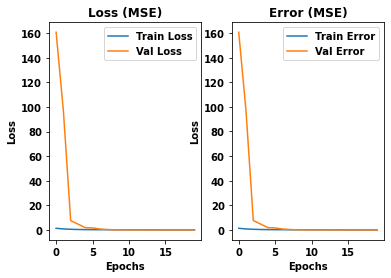

In [ ]:
plot_model_history(model=model)

### Predict

In [ ]:
def ts_data_pred_generator(data_arr, batch_input_len, iter_cnt):
    X = [row for row in data_arr[iter_cnt: iter_cnt+batch_input_len]]
    y = [data_arr[batch_input_len+iter_cnt][0], data_arr[batch_input_len+iter_cnt][1], data_arr[batch_input_len+iter_cnt][2]]
    return np.array(X), np.array(y)

In [ ]:
def create_df_predict(training_csv, testing_csv, batch_input_len):
    df_train = preprocess_cvs_into_ts(training_csv)
    df_train = preprocess_ts_features(df_train)
    df_test = preprocess_cvs_into_ts(testing_csv)
    df_test = preprocess_ts_features(df_test)
    test_len = df_test.shape[0]
    df_pred = pd.concat([df_train, df_test], axis=0)
    df_pred.fillna(0)
    return df_pred[-(test_len+batch_input_len):]

In [ ]:
def model_predict(training_csv, testing_csv, batch_input_len, model):
    '''This method takes the test csv file, gives the output as predicted array
    Creating df which will contain last rows from train which equal to the length of the batch
    append those to the test.
    The first prediction for the test row 0 shall consider data from train and predict the 0 row of test
    the predictions are updated into test first row and then prediction is done for the 1 row in test
    this loop repeats'''
    
    # Creating train (with batch length) and test dataset
    df_solar_pred = create_df_predict(training_csv, testing_csv, batch_input_len)
    
    # Scaling for data
    solar_data_pred_sc = scalar_std_ts.transform(df_solar_pred)
    
    # Used only for testing
    cnt = 0
    
    # Contains the predicted output
    x_pred = []
    
    tst_len = solar_data_pred_sc.shape[0] - batch_input_len
    
    # Runs for the entire X test
    for i in range(tst_len):
        # Tranforming the data into X and y to pass it NN predict
        X_test, y_test = ts_data_pred_generator(solar_data_pred_sc, batch_input_len, i)
    
    
        # Since only one value of (batchlength, features) is passed 
        # it needs to be in the format (n, l, f)
        X_i = np.expand_dims(X_test, axis=0)
        # print('X_i[-1]\n', X_i[0][-1])
        
        # Predicts the next row 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'
        y_i = model.predict(X_i)
        
        # Update predicted 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI' since they are not passed
        solar_data_pred_sc[batch_input_len+i][0:3] = y_i
        
        # print(i, end=', ')
        if i % 1000==0:
            print(f'{i}={y_i}', end=', ')
        
        
    # print('x_i_pred\n', x_i_pred)
    # Removing the train appended values and taking only the test output values
    solar_data_pred_sc = solar_data_pred_sc[batch_input_len:]
    # This trick is used to ensure we are inverse transform. 
    # Inverse transform needs the same length features which was used for fit/transform
    return scalar_std_ts.inverse_transform(solar_data_pred_sc)

##### Debuggin end

In [ ]:
X_pred = model_predict(training_csv, testing_csv, batch_input_len, model)

0=[[-0.8404365  -0.88125837 -0.7677336 ]], 1000=[[0.45970246 1.4480134  0.9078537 ]], 2000=[[1.2139819  0.984621   0.99459684]], 3000=[[-0.75879294 -0.8286028  -0.79411435]], 4000=[[-0.82522917 -0.88345695 -0.7833476 ]], 5000=[[-0.8277106 -0.8870425 -0.7807386]], 6000=[[-0.50550365 -0.5150386  -0.6032603 ]], 7000=[[1.1163881 1.368276  1.7385823]], 8000=[[1.3768162 1.1547583 1.8697939]], 9000=[[ 0.36360535  0.19945431 -0.17000467]], 10000=[[-0.8346309 -0.8918233 -0.7871355]], 11000=[[-0.8441619  -0.90291643 -0.78791595]], 12000=[[-0.66885704 -0.73208475 -0.72486097]], 13000=[[0.850492  1.255281  1.2445558]], 14000=[[1.4548541  0.92791843 1.1210722 ]], 15000=[[-0.7707078  -0.83326036 -0.76244795]], 16000=[[-0.8366474 -0.8933399 -0.7856732]], 17000=[[-0.83008194 -0.8791641  -0.77525   ]], 

In [ ]:
X_pred.shape

(17520, 11)

In [ ]:
def generate_pred_outputfile(X_pred):
    '''This shall generate the output files for submission'''
    # est_period=48*365
    est_period=len(X_pred)
    start_datetime = "2019-01-01 00:00:00"
    pred_indx = pd.date_range(start=start_datetime, periods=est_period, freq="30T")
    y_pred_const = []
    for i in range(len(X_pred)):
        y_pred_const.append(X_pred[i][0:3])

    df_y_pred = pd.DataFrame(data=y_pred_const, index=pred_indx, columns=['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'])
    df_X_pred = pd.DataFrame(data=X_pred, index=pred_indx, columns=COLUMNS_SELECTED)
    df_y_pred.to_csv('submission_y_AnilKagita.csv', index=False)
    df_y_pred.to_csv('verify_y_AnilKagita.csv', index=True)
    df_X_pred.to_csv('verify_x_AnilKagita.csv', index=True)
    return df_y_pred, df_X_pred

In [ ]:
df_y_pred, df_X_pred = generate_pred_outputfile(X_pred)

In [ ]:
def plot_pred_y(df_y_pred):
    plt.figure(figsize=(12, 9))
    cnt = 1
    for col in df_y_pred.columns:
        plt.subplot(3, 1, cnt)
        plt.title(col)
        plt.plot(df_y_pred[col], label=col)
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        cnt += 1

    plt.tight_layout()
    plt.show()

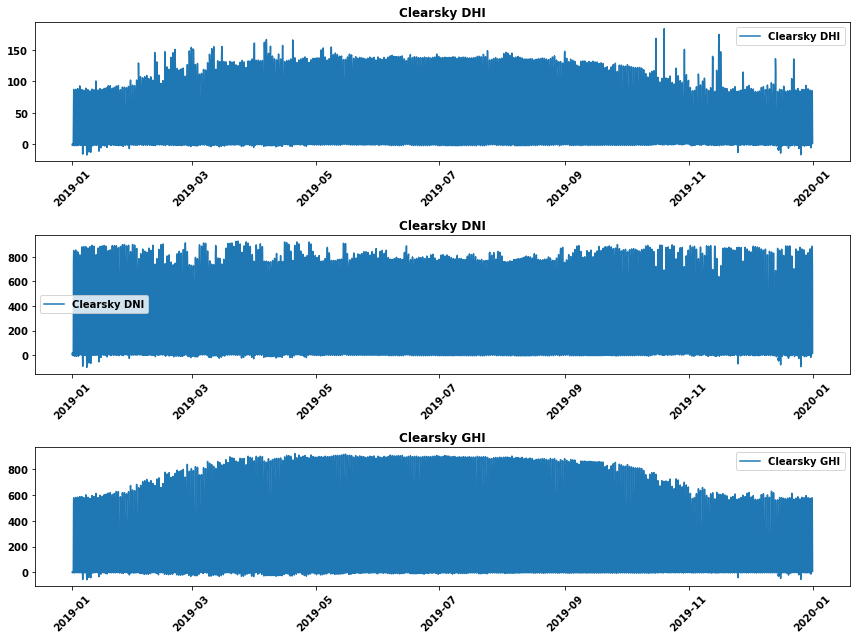

In [ ]:
plot_pred_y(df_y_pred)

In [ ]:
def plot_train_test(df_train_plot, df_test_plot):
    plt.figure(figsize=(12, 9))
    cnt = 1
    for col in df_y_pred.columns:
        plt.subplot(3, 1, cnt)
        plt.title(col)
        plt.plot(df_train_plot[col], label='train')
        plt.plot(df_test_plot[col], label='test')
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        cnt += 1

    plt.tight_layout()
    plt.show()

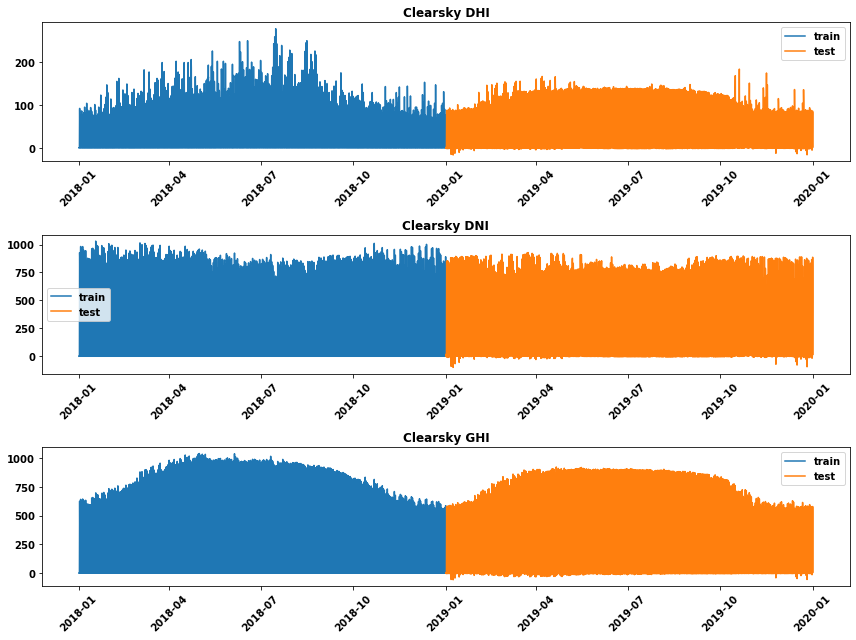

In [ ]:
plot_train_test(df_solar[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']][-len(X_pred):], df_y_pred)

# Process Using the Standard Stats TimeSeries Models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
COLUMN_LIST_GIVEN = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Solar Zenith Angle', 'Precipitable Water',
                     'Temperature', 'Relative Humidity']

In [4]:
def convert_ts_csv_to_df(csvfile):
    '''Take the CSV file along with the path and return dataframe'''
    df = pd.read_csv(csvfile)
    df.insert(loc=0, column='Date', 
                value=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
    df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    df.set_index(keys='Date', inplace=True)
    
    df=df[COLUMN_LIST_GIVEN]
    df.index.freq = '0.5H'
    return df

In [5]:
training_csv = '/content/drive/MyDrive/Colab Notebooks/data/train.csv'
testing_csv = '/content/drive/MyDrive/Colab Notebooks/data/test.csv'

In [6]:
df_solar_stat = convert_ts_csv_to_df(training_csv)
df_solar_stat.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Solar Zenith Angle,Precipitable Water,Temperature,Relative Humidity
Date,,,,,,,
2010-08-19 23:00:00,72,435,183,75.22,6.101,30.0,69.71
2017-03-07 22:00:00,103,510,273,70.53,3.292,20.0,80.85


In [7]:
df_solar_stat_test = convert_ts_csv_to_df(testing_csv)
df_solar_stat_test.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Solar Zenith Angle,Precipitable Water,Temperature,Relative Humidity
Date,,,,,,,
2019-04-23 17:30:00,NaN,NaN,NaN,19.27,2.2,27.2,48.42
2019-06-15 21:30:00,NaN,NaN,NaN,51.94,2.9,31.8,39.74


In [8]:
df_solar_stat.shape, df_solar_stat_test.shape

((175296, 7), (17520, 7))

In [9]:
def plot_training_columns(df):
    plt.figure(figsize=(12, 9))
    cnt = 1
    for col in df.columns:
        plt.subplot(3, 1, cnt)
        plt.title('One month data of ' +col)
        plt.plot(df[col], label=col)
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        cnt += 1

    plt.tight_layout()
    plt.show()

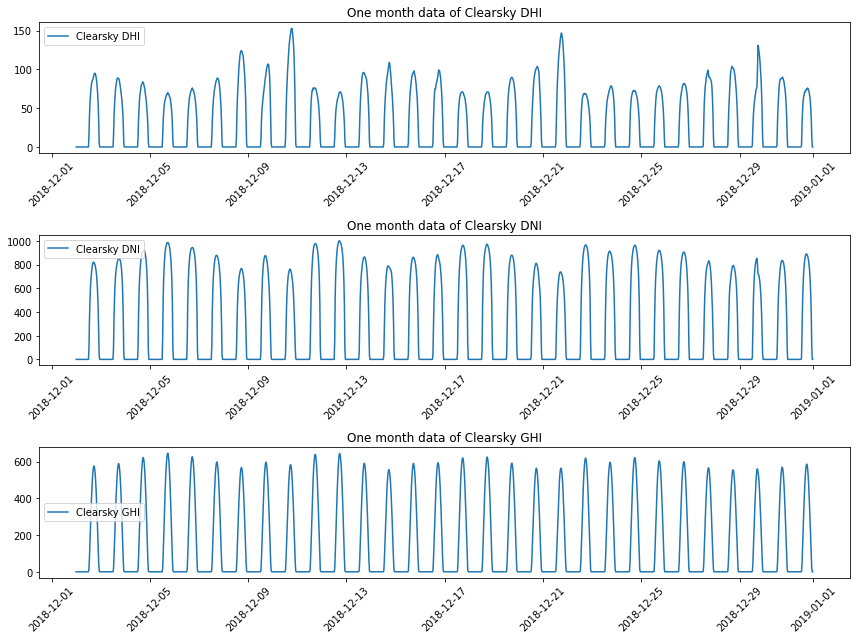

In [10]:
plot_training_columns(df_solar_stat.iloc[:, 0:3][-48*30:])

In [11]:
def plot_monthwise_data(df):
    plt.figure(figsize=(12, 15))
    cnt = 1
    for col in df.columns:
        plt.subplot(3, 1, cnt)
        plt.title('Month wise spead of ' +col)
        sns.boxplot(x=df.index.month, y=df[col])
        plt.xticks(rotation=45)
        cnt += 1

    plt.tight_layout()
    plt.show()

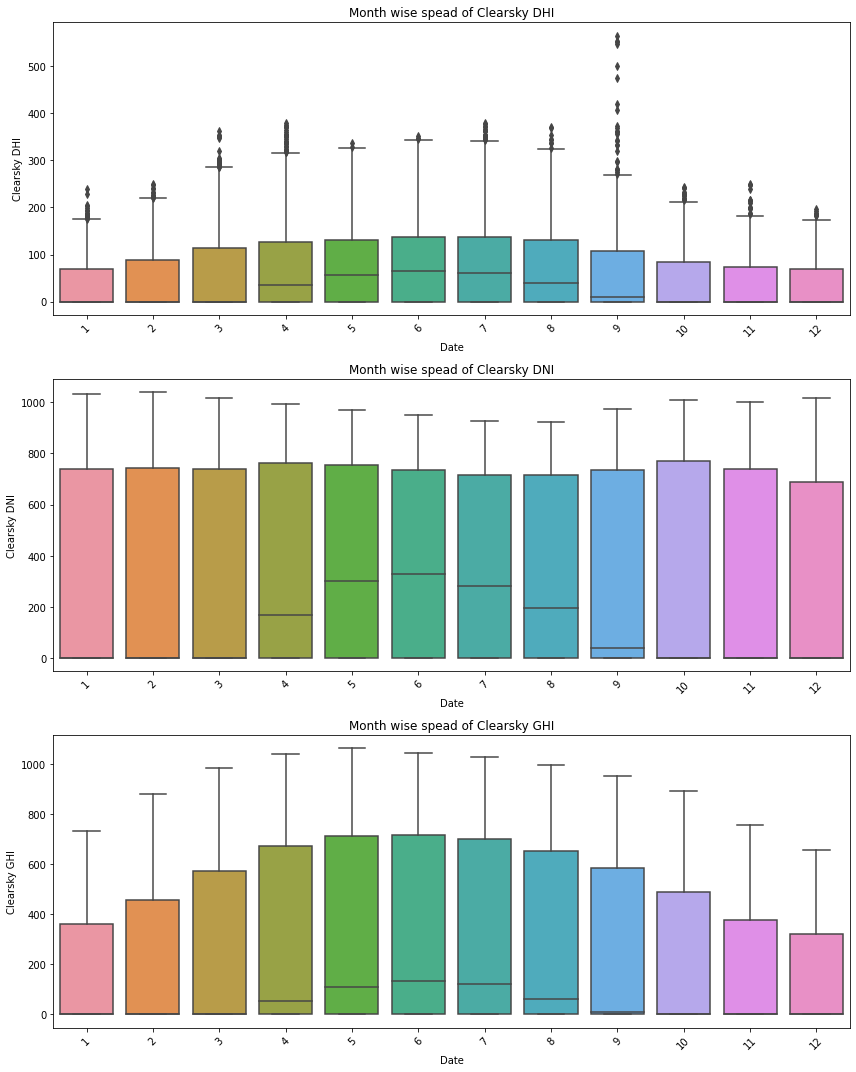

In [12]:
plot_monthwise_data(df_solar_stat.iloc[:, 0:3])

In [13]:
def plot_daywise_data(df):
    plt.figure(figsize=(12, 15))
    cnt = 1
    for col in df.columns:
        plt.subplot(3, 1, cnt)
        plt.title('Month wise spead of ' +col)
        sns.boxplot(x=df.index.hour, y=df[col])
        plt.xticks(rotation=45)
        cnt += 1

    plt.tight_layout()
    plt.show()

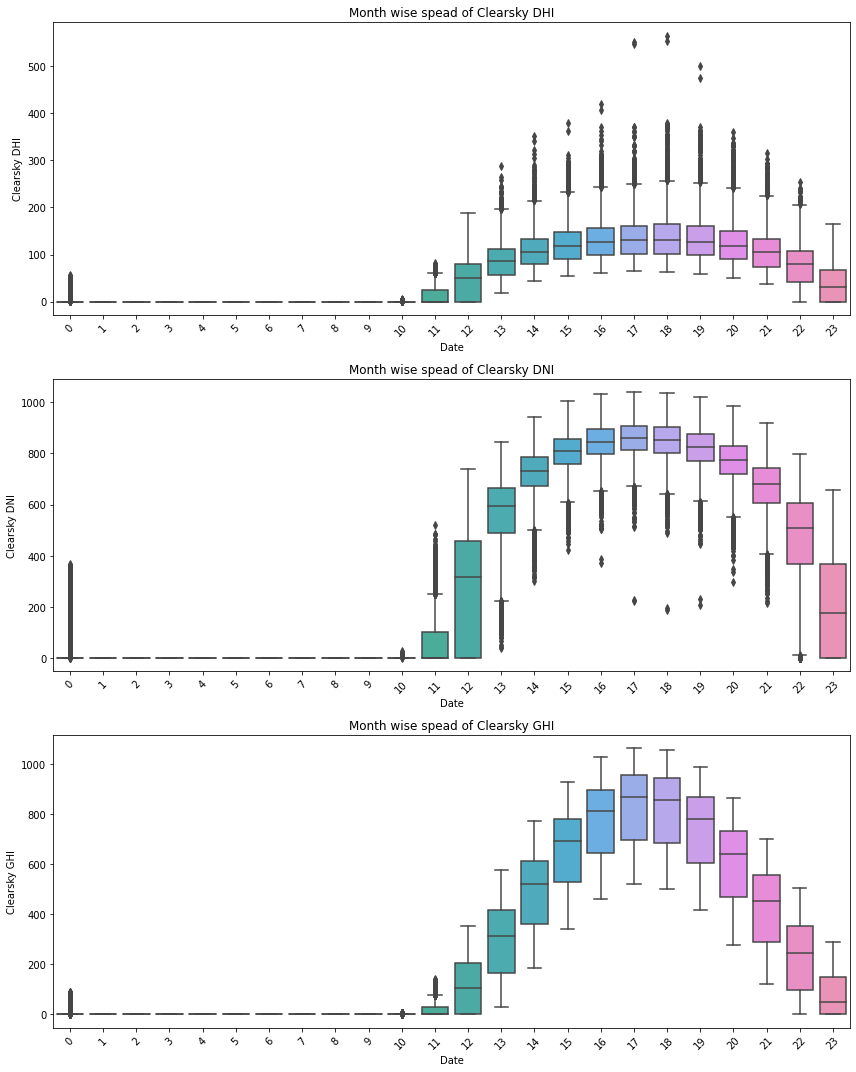

In [14]:
plot_daywise_data(df_solar_stat.iloc[:, 0:3])

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
def plot_seasonal_decomposition(df, mode='additional'):
    plt.figure(figsize=(12, 15))
    cnt = 1
    for col in df.columns:
        plt.subplot(3, 1, cnt)
        plt.title('Month wise spead of ' +col)
        decompose = seasonal_decompose(df[col], model=mode)
        decompose.plot()
        cnt += 1

    plt.tight_layout()
    plt.show()

##### Cann't Decompose the sequence since the time period '30T' is not supported. This is a defect in python

In [17]:
# plot_seasonal_decomposition(df_solar_stat.iloc[:, 0:3])

### Stationarity Check

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def test_stationarity(df):
    for col in df.columns:
        data = df[col].values
        results = adfuller(data)
        print(f'AdFuller test for: {col}')
        print(f'ADF Statistic: {results[0]}')
        print(f'p-value: {results[1]}')
        if results[1]<0.05:
            print(f'{col} is stationary\n')
        else:
            print(f'{col} is not-stationary, need to further differentiate to make it stationary\n')

In [20]:
test_stationarity(df_solar_stat.iloc[:, 0:3])

AdFuller test for: Clearsky DHI
ADF Statistic: -19.638056559253815
p-value: 0.0
Clearsky DHI is stationary

AdFuller test for: Clearsky DNI
ADF Statistic: -31.261699193863116
p-value: 0.0
Clearsky DNI is stationary

AdFuller test for: Clearsky GHI
ADF Statistic: -4.40013753035363
p-value: 0.00029666631135956
Clearsky GHI is stationary



Splitting the Data into Train, Val and Test

In [9]:
df_solar_stat.shape, df_solar_stat_test.shape

((175296, 7), (17520, 7))

In [10]:
val_length = 48*365
train_length = 48*365*3 + val_length
test_length = df_solar_stat_test.shape[0]
print(f'''Train Length: {train_length}, Val Length: {val_length}, Test Length: {test_length}, ''')

Train Length: 70080, Val Length: 17520, Test Length: 17520, 


In [11]:
y_train_DHI = df_solar_stat.iloc[-train_length:-val_length, 0]
y_val_DHI = df_solar_stat.iloc[-val_length:, 0]
y_test_DHI = df_solar_stat_test.iloc[:, 0]
X_train_DHI = df_solar_stat.iloc[-train_length:-val_length, 3:5]
X_val_DHI = df_solar_stat.iloc[-val_length:, 3:5]
X_test_DHI = df_solar_stat_test.iloc[:, 3:5]

y_train_DNI = df_solar_stat.iloc[-train_length:-val_length, 1]
y_val_DNI = df_solar_stat.iloc[-val_length:, 1]
y_test_DNI = df_solar_stat_test.iloc[:, 1]
X_train_DNI = df_solar_stat.iloc[-train_length:-val_length, 3:5]
X_val_DNI = df_solar_stat.iloc[-val_length:, 3:5]
X_test_DNI = df_solar_stat_test.iloc[:, 3:5]


y_train_GHI = df_solar_stat.iloc[-train_length:-val_length, 2]
y_val_GHI = df_solar_stat.iloc[-val_length:, 2]
y_test_GHI = df_solar_stat_test.iloc[:, 2]
X_train_GHI = df_solar_stat.iloc[-train_length:-val_length, 3:5]
X_val_GHI = df_solar_stat.iloc[-val_length:, 3:5]
X_test_GHI = df_solar_stat_test.iloc[:, 3:5]


In [34]:
df_solar_stat.columns

Index(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Solar Zenith Angle',
       'Precipitable Water', 'Temperature', 'Relative Humidity'],
      dtype='object')

Testing for Models Orders

In [38]:
#pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 19.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [10]:
from pmdarima import auto_arima

In [ ]:
auto_arima(df_solar_stat.iloc[:,0], seasonality=True, m=48).summary()

In [ ]:
auto_arima(df_solar_stat.iloc[:,1], seasonality=True, m=48).summary()

In [ ]:
auto_arima(df_solar_stat.iloc[:,2], seasonality=True, m=48).summary()

In [18]:
y_train_GHI

Date
2015-01-02 00:00:00      0
2015-01-02 00:30:00      0
2015-01-02 01:00:00      0
2015-01-02 01:30:00      0
2015-01-02 02:00:00      0
                      ... 
2017-12-31 21:30:00    152
2017-12-31 22:00:00     70
2017-12-31 22:30:00      9
2017-12-31 23:00:00      0
2017-12-31 23:30:00      0
Freq: 30T, Name: Clearsky GHI, Length: 52560, dtype: int64

In [ ]:
auto_arima(y_train_GHI, X=X_train_GHI, seasonal=True, stationary=True, m=48, verbose=1).summary()

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,0,1)[48] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 512, in _fit_wrapper
    **fit_args)
  File "/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 709, in fit
    skip_hessian=True, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py", line

Checking for p and q Values. We know that d=0 since the data is stationary

In [8]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

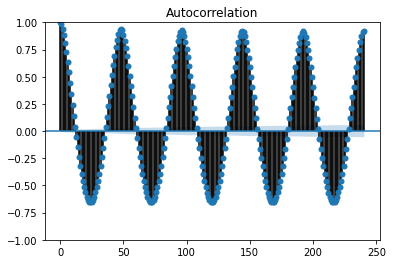

In [17]:
plot_acf(x=df_solar_stat.iloc[:, 0], lags=240);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


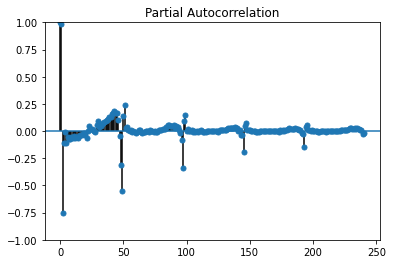

In [20]:
plot_pacf(x=df_solar_stat.iloc[:, 0], lags=96);

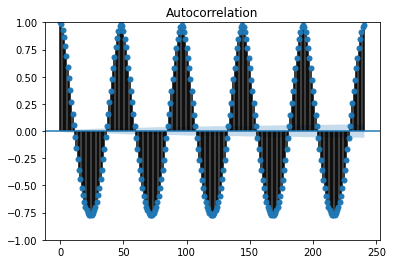

In [19]:
plot_acf(x=df_solar_stat.iloc[:, 1], lags=240);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


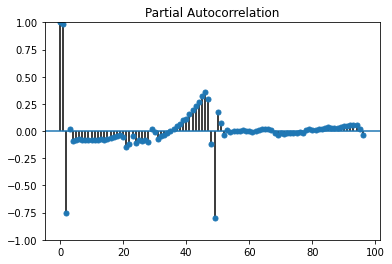

In [21]:
plot_pacf(x=df_solar_stat.iloc[:, 1], lags=96);

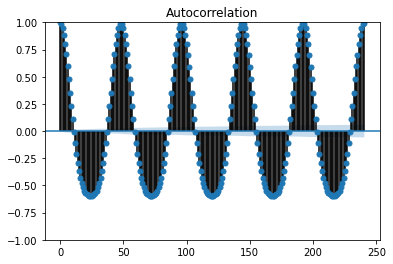

In [22]:
plot_acf(x=df_solar_stat.iloc[:, 2], lags=240);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


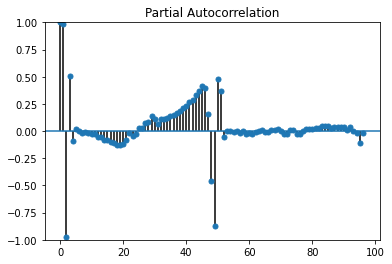

In [23]:
plot_pacf(x=df_solar_stat.iloc[:, 2], lags=96);

Building a SARIMAX models with exogeneous data elements

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
import itertools
p = q = range(0, 3)
d = range(0, 1)
param_pdq = list(itertools.product(p, d, q))
param_PDQ = [(x[0], x[1], x[2], 48) for x in list(itertools.product(p, d, q))]

In [ ]:
# Storing the AIC values of each model with different params
df_aic_scores_DHI = pd.DataFrame()

# Running the model in iterations to get the best model DHI
for param in param_pdq:
  for sparam in param_PDQ:
    mod = SARIMAX(endog=df_solar_stat.iloc[:, 0], exog=df_solar_stat.iloc[:, 3:5], 
                  order=param, seasonal_order=sparam, 
                  enforce_stationarity=False, enforce_invertibility=False)
    mod = mod.fit()
    df_aic_scores_DHI = df_aic_scores_DHI.append({
        'param':param,
        'seasonalparam': sparam,
        'AIC Score': mod.aic
    },  ignore_index=True)
    print(f'''SARIMA params:{param}, seasonal params:{sparam}, AIC:{mod.aic}''')



SARIMA params:(0, 0, 0), seasonal params:(0, 0, 0, 48), AIC:1929857.2526091912


In [ ]:
# Storing the AIC values of each model with different params
df_aic_scores_DNI = pd.DataFrame()

# Running the model in iterations to get the best model DNI
for param in param_pdq:
  for sparam in param_PDQ:
    mod = SARIMAX(endog=df_solar_stat.iloc[:, 1], exog=df_solar_stat.iloc[:, 3:5], 
                  order=param, seasonal_order=sparam, 
                  enforce_stationarity=False, enforce_invertibility=False)
    mod = mod.fit()
    df_aic_scores_DNI = df_aic_scores_DNI.append({
        'param':param,
        'seasonalparam': sparam,
        'AIC Score': mod.aic
    },  ignore_index=True)
    print(f'''SARIMA params:{param}, seasonal params:{sparam}, AIC:{mod.aic}''')


In [ ]:
# Storing the AIC values of each model with different params
df_aic_scores_GHI = pd.DataFrame()

# Running the model in iterations to get the best model GHI
for param in param_pdq:
  for sparam in param_PDQ:
    mod = SARIMAX(endog=df_solar_stat.iloc[:, 2], exog=df_solar_stat.iloc[:, 3:5], 
                  order=param, seasonal_order=sparam, 
                  enforce_stationarity=False, enforce_invertibility=False)
    mod = mod.fit()
    df_aic_scores_GHI = df_aic_scores_GHI.append({
        'param':param,
        'seasonalparam': sparam,
        'AIC Score': mod.aic
    },  ignore_index=True)
    print(f'''SARIMA params:{param}, seasonal params:{sparam}, AIC:{mod.aic}''')

### Build a VARMAX model

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_model import ARMA, ARMAResults
from statsmodels.tsa.ar_model import AR, ARResults

In [ ]:
df_solar_stat = df_solar_stat.astype(np.float64)

In [ ]:
model_varmax1 = VARMAX(endog=df_solar_stat.iloc[-48*365*2:, 0:3], exog=df_solar_stat.iloc[-48*365*2:, 3:], order=(1, 2), trend='c')
model_varmax1_results = model_varmax1.fit(maxiter=1000, disp=False)
model_varmax1_results.summary()

In [ ]:
df_solar_stat.dtypes

Clearsky DHI          float64
Clearsky DNI          float64
Clearsky GHI          float64
Solar Zenith Angle    float64
Temperature           float64
Precipitable Water    float64
Relative Humidity     float64
dtype: object